In [251]:
# OD to network.
# pour un seul dijktra. trouver les temps sur les liens pour chauew OD. (prendre la moyenne)

In [252]:
import requests
import urllib.request
import json
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString
import datetime
import random
import matplotlib
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [253]:
def add_geometry_coordinates(df, columns=['x_geometry', 'y_geometry']):
    """Append centroid coordinates to GeoDataFrame 

    Parameters
    ----------
    df : GeoDataFrame
        _description_
    columns : list, optional
        Names for the coordinates columns, by default ['x_geometry', 'y_geometry']

    Returns
    -------
    GeoDataFrame
        GeoDataFrame with centroid coordinates columns.
    """
    df = df.copy()

    # if the geometry is not a point...
    centroids = df['geometry'].apply(lambda g: g.centroid)

    df[columns[0]] = centroids.apply(lambda g: g.coords[0][0])
    df[columns[1]] = centroids.apply(lambda g: g.coords[0][1])
    return df
def nearest(one, nbrs):

    try:
        # assert df_many.index.is_unique
        assert one.index.is_unique
    except AssertionError:
        msg = 'index of one and many should not contain duplicates'
        print(msg)

    df_one = add_geometry_coordinates(one.copy(), columns=['x_geometry', 'y_geometry'])

    # x = df_many[['x_geometry','y_geometry']].values
    y = df_one[['x_geometry', 'y_geometry']].values

    distances, indices = nbrs.kneighbors(y)

    indices = pd.DataFrame(indices)
    distances = pd.DataFrame(distances)
    indices = pd.DataFrame(indices.stack(), columns=['index_nn']).reset_index().rename(
        columns={'level_0': 'ix_one', 'level_1': 'rank'})
    indices

    return indices

In [254]:
from numba import jit
import numba as nb


@jit(nopython=True,locals={'predecessors':nb.int32[:,::1]},parallel=True) #parallel=True
def fast_assign_time(odt,predecessors,times,counter,links_time):
    # this function use parallelization (or not).nb.set_num_threads(num_cores)
    # volumes is a numba dict with all the key initialized
    for i in nb.prange(len(odt)): #nb.prange(len(odv)):
        origin = odt[i,0]
        destination = odt[i,1]
        t=odt[i,2]
        path = get_node_path(predecessors, origin, destination)
        path = list(zip(path[:-1], path[1:]))
        tot_time =0
        for key in path:
            tot_time += links_time[key]

        for key in path:
            new_t = t*links_time[key]/tot_time
            count = counter[key]
            times[key] = (times[key]*count + new_t) / (count+1)
            counter[key] = count+1
    return times




def assign_time(odt,links_time,predecessors,volumes_sparse_keys,reversed_index):
    # create dict to create an average of time on each link. 
    # the average in weighted by the links_time/total_time
    numba_times = nb.typed.Dict.empty(
        key_type=nb.types.UniTuple(nb.types.int64, 2), 
        value_type=nb.types.float64
        )
    numba_counter = nb.typed.Dict.empty(
        key_type=nb.types.UniTuple(nb.types.int64, 2), 
        value_type=nb.types.int64
        )
    numba_links_time = nb.typed.Dict.empty(
        key_type=nb.types.UniTuple(nb.types.int64, 2), 
        value_type=nb.types.float64
        )
    for key in volumes_sparse_keys:
        numba_times[key] = 0
        numba_counter[key] = 0
        numba_links_time[key] = links_time[key]
    #assign volumes from each od
    times = dict(fast_assign_time(odt,predecessors,numba_times,numba_counter,numba_links_time))
    
    ab_times = {
        (reversed_index[k[0]], reversed_index[k[1]]) : t 
        for k, t in times.items()
        }
    return ab_times



@jit(nopython=True,locals={'predecessors':nb.int32[:,::1]},parallel=True) #parallel=True
def fast_get_time(odt,predecessors,times,new_time_dict):
    # this function use parallelization (or not).nb.set_num_threads(num_cores)
    # volumes is a numba dict with all the key initialized
    for i in nb.prange(len(odt)): #nb.prange(len(odv)):
        origin = odt[i,0]
        destination = odt[i,1]
        path = get_node_path(predecessors, origin, destination)
        path = list(zip(path[:-1], path[1:]))
        val=0
        for key in path:
            val += new_time_dict[key]
        times[(origin,destination)]=val

    return times

def get_od_time(odt,new_time_dict,volumes_sparse_keys,predecessors):
    numba_new_time_dict = nb.typed.Dict.empty(
            key_type=nb.types.UniTuple(nb.types.int64, 2), 
            value_type=nb.types.float64
            )
    numba_times = nb.typed.Dict.empty(
        key_type=nb.types.UniTuple(nb.types.int64, 2), 
        value_type=nb.types.float64
        )
    for key in volumes_sparse_keys:
        numba_new_time_dict[key] = new_time_dict[key]
    for i,j,_ in odt:
        numba_times[(i,j)] = 0
    times = fast_get_time(odt,predecessors,numba_times,numba_new_time_dict)
    return dict(times)

In [255]:

links = gpd.read_file('../../../Downloads/S1/network/links.geojson')
links['time'] = links['length']/links['speedau']
links['time'] = links['time']*3600

mean_speed = (links['speedau']*links['length']).mean()/links['length'].mean()
links['time_ff'] = links['length']/mean_speed
links['time_ff'] = links['time_ff']*3600

links[np.isfinite(links['time'])]
links = links.reset_index(drop=True)
links.index = 'link_'+links.index.astype(str)
links['length'] = links['length']*1000
#links
links = links.rename(columns={'i':'a','j':'b'})
links = links[['a', 'b','length', 'time','time_ff']]
links['a'] = 'node_'+links['a'].astype(str)
links['b'] = 'node_'+links['b'].astype(str)
links.index.name='index'

In [256]:
nodes = gpd.read_file('../../../Downloads/S1/network/nodes.geojson')
nodes['ID'] = 'node_'+nodes['ID'].astype(str)
nodes_set = set(links['a'].unique()).union(set(links['b'].unique()))
nodes = nodes[nodes['ID'].isin(nodes_set)]
nodes = nodes.set_index('ID')
nodes = nodes.reset_index()
node_dict = nodes['ID'].to_dict()
nodes = nodes.set_index('ID')

In [257]:
links

,a,b,length,time,time_ff
index,,,,,
link_0,node_1,node_1490,119.994,29.998500,8.720489
link_1,node_1,node_12430,77.706,30.015193,5.647235
link_2,node_2,node_12449,236.065,29.997670,17.155876
link_3,node_3,node_12360,132.616,30.007392,9.637785
link_4,node_3,node_12363,133.906,29.997610,9.731534
...,...,...,...,...,...
link_22118,node_40913,node_312,27.171,30.004785,1.974635
link_22119,node_40913,node_1021,105.084,10.930436,7.636914
link_22120,node_40913,node_1061,179.644,18.325826,13.055515


In [258]:
nodes

,X,Y,DATA1,DATA2,DATA3,ISZONE,ISINTERSEC,LABEL,INBOAI,FIALII,...,@pnr_capac,@secteur,@tag_arret,@type_term,@zat,@zat_tc_ty,#arrondiss,#lieu_fina,#quartier,geometry
ID,,,,,,,,,,,,,,,,,,,,,
node_1,250606.855883,5.186099e+06,34569.0,0.0,0.0,1,0,None,196.017270,308.192260,...,0.0,11.0,0.0,0.0,1.0,0.0,La Cite-Limoilou,Tunis,Vieux-Quebec/Cap-Blanc/Colline parlementaire,POINT (250606.856 5186098.704)
node_2,250678.406997,5.185640e+06,34523.0,0.0,0.0,1,0,None,8.945572,23.179955,...,0.0,11.0,0.0,0.0,2.0,0.0,La Cite-Limoilou,Artois,Vieux-Quebec/Cap-Blanc/Colline parlementaire,POINT (250678.407 5185639.770)
node_3,250877.058856,5.186144e+06,34578.0,0.0,0.0,1,0,None,12.152803,56.327293,...,0.0,11.0,0.0,0.0,3.0,0.0,La Cite-Limoilou,Berline,Vieux-Quebec/Cap-Blanc/Colline parlementaire,POINT (250877.059 5186144.402)
node_4,250888.496094,5.185931e+06,34524.0,0.0,0.0,1,0,None,56.294334,58.196808,...,0.0,11.0,0.0,0.0,4.0,0.0,La Cite-Limoilou,Berline,Vieux-Quebec/Cap-Blanc/Colline parlementaire,POINT (250888.496 5185930.975)
node_5,250990.229068,5.186356e+06,34525.0,0.0,0.0,1,0,None,87.182091,192.648710,...,0.0,11.0,0.0,0.0,5.0,0.0,La Cite-Limoilou,Royale,Vieux-Quebec/Cap-Blanc/Colline parlementaire,POINT (250990.229 5186355.710)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
node_40908,250502.219500,5.188475e+06,0.0,0.0,0.0,0,0,None,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None,POINT (250502.219 5188474.941)
node_40909,241445.947506,5.179638e+06,0.0,0.0,0.0,0,0,None,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None,POINT (241445.948 5179638.077)
node_40910,237735.361930,5.183962e+06,0.0,0.0,0.0,0,0,None,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,None,None,None,POINT (237735.362 5183961.885)


In [259]:
zones = gpd.read_file('../../../Downloads/base/zones/Zat_TC.geojson')
centroid = zones.copy()
centroid['geometry'] = centroid.centroid

In [260]:
from sklearn.neighbors import NearestNeighbors
x = nodes[['X', 'Y']].values
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(x)
neigh = nearest(centroid,nbrs)

In [261]:
node_index = neigh['index_nn'].to_dict()
centroid['node_index'] = centroid.index.map(node_index.get)
centroid['node_index'] = centroid['node_index'].apply(lambda x: node_dict.get(x))

In [262]:
centroid = centroid.reset_index().rename(columns={'index':'a','node_index':'b'})
centroid['a'] = 'zone_'+centroid['a'].astype(str)
centroid = centroid[['a','b']]

In [263]:
zones_to_road = pd.concat([centroid,centroid.rename(columns={'a':'b','b':'a'})])

In [264]:
zones_to_road['length'] = 0
zones_to_road['time'] = 0
zones_to_road['time_ff'] = 0
zones_to_road = zones_to_road.reset_index(drop=True)

In [265]:
zones_to_road.index = 'zlink_' + zones_to_road.index.astype(str)

In [266]:
centroid

,a,b
0,zone_0,node_1
1,zone_1,node_2
2,zone_2,node_3
3,zone_3,node_4
4,zone_4,node_5
...,...,...
885,zone_885,node_770
886,zone_886,node_35304
887,zone_887,node_772
888,zone_888,node_29172


In [267]:
df = pd.concat([links,zones_to_road])
df

,a,b,length,time,time_ff
link_0,node_1,node_1490,119.994,29.998500,8.720489
link_1,node_1,node_12430,77.706,30.015193,5.647235
link_2,node_2,node_12449,236.065,29.997670,17.155876
link_3,node_3,node_12360,132.616,30.007392,9.637785
link_4,node_3,node_12363,133.906,29.997610,9.731534
...,...,...,...,...,...
zlink_1775,node_770,zone_885,0.000,0.000000,0.000000
zlink_1776,node_35304,zone_886,0.000,0.000000,0.000000
zlink_1777,node_772,zone_887,0.000,0.000000,0.000000
zlink_1778,node_29172,zone_888,0.000,0.000000,0.000000


In [268]:
from quetzal.engine.road_pathfinder import sparse_matrix, parallel_dijkstra
from scipy.sparse.csgraph import dijkstra
def road_routing(origin,destination,mat,node_index,dijkstra_limit=np.inf,return_predecessors=False):
    # simple routing scipy wrapper for GTFS routing
    #
    index_node = {v: k for k, v in node_index.items()}
    # liste des origines pour le dijkstra
    origin_sparse = [node_index[x] for x in origin]
    
    # dijktra on the road network from node = incices to every other nodes.
    # from b to a.
    dist_matrix, predecessors = dijkstra(
        csgraph=mat,
        directed=True,
        indices=origin_sparse,
        return_predecessors=True,
        limit=dijkstra_limit
    )

    dist_matrix = pd.DataFrame(dist_matrix)
    dist_matrix.index = origin
    # filtrer. on garde seulement les destination d'intéret
    destination_sparse = [node_index[x] for x in destination]
    dist_matrix = dist_matrix[destination_sparse]
    dist_matrix = dist_matrix.rename(columns=index_node)
    if return_predecessors:
        return dist_matrix,predecessors
    else: 
        return dist_matrix

In [269]:
zones = centroid['a'].unique()

In [250]:
mat,indices = sparse_matrix(df[['a','b','time']].values)
od_time_quebec = road_routing(zones,zones,
                 mat,
                 indices)

mat,indices = sparse_matrix(df[['a','b','time_ff']].values)
od_timeff_quebec = road_routing(zones,zones,
                 mat,
                 indices)

od_time_quebec.mean().mean()/60


KeyError: 1863

 on peut utiliser directement nos data pour tester la reconstruction du reseau routier, pas besoins de de prdiction

# network reconstructions

In [149]:
def format_data2(od_time,od_timeff):
    df = od_time.stack().reset_index().rename(columns={'level_0':'origin','level_1':'destination',0:'time'})
    timeff_dict = od_timeff.stack().reset_index().rename(columns={'level_0':'origin','level_1':'destination',0:'time_ff'})['time_ff'].to_dict()
    df['time_ff'] = df.index.map(timeff_dict.get)
    df['residual'] = df['time']-df['time_ff']
    #df = df[['origin','destination','time','time_ff','residual','o_geometry','d_geometry']]
    df = df[['origin','destination','time']]
    return df

In [150]:
od = format_data2(od_time_quebec,od_timeff_quebec)


In [151]:
od

,origin,destination,time
0,zone_0,zone_0,0.000000
1,zone_0,zone_1,91.485771
2,zone_0,zone_2,121.471542
3,zone_0,zone_3,121.466245
4,zone_0,zone_4,140.248033
...,...,...,...
792095,zone_889,zone_885,2069.012300
792096,zone_889,zone_886,2079.277869
792097,zone_889,zone_887,1649.319320
792098,zone_889,zone_888,366.842621


In [152]:
from quetzal.engine.pathfinder_utils import build_index,get_edge_path,get_node_path
from quetzal.engine.msa_utils import get_zone_index


In [153]:
# use time here. we need the read time for each OD (like a call to google api)
edges = df[['a','b','time']].values # to build the index once and for all
index = build_index(edges)
reversed_index = {v:k for k, v in index.items()}
od,zones = get_zone_index(df,od,index)
od

,origin,destination,time,o,d
0,zone_0,zone_0,0.000000,0,1863
1,zone_0,zone_1,91.485771,0,6228
2,zone_0,zone_2,121.471542,0,2529
3,zone_0,zone_3,121.466245,0,6796
4,zone_0,zone_4,140.248033,0,8168
...,...,...,...,...,...
792095,zone_889,zone_885,2069.012300,877,5234
792096,zone_889,zone_886,2079.277869,877,2147
792097,zone_889,zone_887,1649.319320,877,4696
792098,zone_889,zone_888,366.842621,877,8004


In [154]:
odt = od[['o','d','time']].values

In [155]:
edges = df[['a','b','time_ff']].values # to build the index once and for all
index = build_index(edges)
reversed_index = {v:k for k, v in index.items()}
sparse, _ = sparse_matrix(edges, index=index)
        
_ , predecessors = parallel_dijkstra(sparse,
                                     directed=True,
                                     indices=zones,
                                     return_predecessors=True,
                                     num_core=1,
                                     keep_running=False)

In [156]:
df['sparse_a'] = df['a'].apply(lambda x:index.get(x))
df['sparse_b'] = df['b'].apply(lambda x:index.get(x))
time_sparse_keys = list(zip(df['sparse_a'],df['sparse_b']))


In [160]:
od

,origin,destination,time,o,d
0,zone_0,zone_0,0.000000,0,1863
1,zone_0,zone_1,91.485771,0,6228
2,zone_0,zone_2,121.471542,0,2529
3,zone_0,zone_3,121.466245,0,6796
4,zone_0,zone_4,140.248033,0,8168
...,...,...,...,...,...
792095,zone_889,zone_885,2069.012300,877,5234
792096,zone_889,zone_886,2079.277869,877,2147
792097,zone_889,zone_887,1649.319320,877,4696
792098,zone_889,zone_888,366.842621,877,8004


In [157]:
df['new_time'] = df['time_ff']


In [163]:
od

,origin,destination,time,o,d
0,zone_0,zone_0,0.000000,0,1863
1,zone_0,zone_1,91.485771,0,6228
2,zone_0,zone_2,121.471542,0,2529
3,zone_0,zone_3,121.466245,0,6796
4,zone_0,zone_4,140.248033,0,8168
...,...,...,...,...,...
792095,zone_889,zone_885,2069.012300,877,5234
792096,zone_889,zone_886,2079.277869,877,2147
792097,zone_889,zone_887,1649.319320,877,4696
792098,zone_889,zone_888,366.842621,877,8004


In [173]:
%%time
errors=[]
links_time = df.set_index(['sparse_a','sparse_b'])['new_time'].to_dict()

edges = df[['a','b','new_time']].values # to build the index once and for all
index = build_index(edges)
reversed_index = {v:k for k, v in index.items()}
sparse, _ = sparse_matrix(edges, index=index)

_ , predecessors = parallel_dijkstra(sparse,
                                     directed=True,
                                     indices=zones,
                                     return_predecessors=True,
                                     num_core=1,
                                     keep_running=False)


times={}
for origin, destination, time in odt: 

    path = get_edge_path(get_node_path(predecessors, origin, destination))
    tot_time = sum([*map(links_time.get,path)])
    for key in path:
        try:
            times[key].append(time*links_time[key]/tot_time)
        except KeyError:
            times[key] = [time*links_time[key]/tot_time]
#return volumes            
# ab_volume is the volume assigned to each link indexed by the (a, b) tuple
ab_times = {
    (reversed_index[k[0]], reversed_index[k[1]]) : np.mean(v)
    for k, v in times.items()
}

df['time_correction'] = df.set_index(['a','b']).index.map(ab_times.get)
df.loc[np.isfinite(df['time_correction']),'new_time'] = df.loc[np.isfinite(df['time_correction']),'time_correction']
'''
new_time_dict = df.set_index(['sparse_a','sparse_b'])['new_time'].to_dict()
times = {}
for origin, destination, time in odt: 
    path = get_edge_path(get_node_path(predecessors, origin, destination))
    times[(origin,destination)] = sum([*map(new_time_dict.get, path)])
od['new_time'] = od.set_index(['o','d']).index.map(times.get)
errors.append(round(np.mean(abs(od['time']-od['new_time'])/60), 2))
print(errors[-1])
'''

CPU times: user 1.97 s, sys: 48.7 ms, total: 2.02 s
Wall time: 2.03 s


"\nnew_time_dict = df.set_index(['sparse_a','sparse_b'])['new_time'].to_dict()\ntimes = {}\nfor origin, destination, time in odt: \n    path = get_edge_path(get_node_path(predecessors, origin, destination))\n    times[(origin,destination)] = sum([*map(new_time_dict.get, path)])\nod['new_time'] = od.set_index(['o','d']).index.map(times.get)\nerrors.append(round(np.mean(abs(od['time']-od['new_time'])/60), 2))\nprint(errors[-1])\n"

In [231]:
#
# enlever le link_time[key]: multiplier a la fin.
# caper la vitesse. (min et max, pendant/avant le mean.)
# graph sur la vitesses des liens

# < --- >
# Reconstruire le reseau avec seulement les requetes
# comparer les temps OD sur le reseau construit au temps relle.
# ==> qualite predictive du reseau reconstruit (unpeu comme KNN mais sur reseau. substitution) (avec un trin et test set.)
# utiliser ce reseu comme reseau dentr/ pour KNN (estimer les redidus.)

# KNN 2 cas. 1) densifier la matrice OD dentrainement du reseau.
#            2) corriger les temps OD issue du reseau entraine. (residue)
# < --- >

In [104]:
%%time
nb.set_num_threads(4)
log_error=True
df['new_time'] = df['time_ff']
times_sparse_keys = list(zip(df['sparse_a'],df['sparse_b']))
errors=[]
for i in range(20):
    links_time = df.set_index(['sparse_a','sparse_b'])['new_time'].to_dict()
    
    edges = df[['a','b','new_time']].values # to build the index once and for all
    index = build_index(edges)
    reversed_index = {v:k for k, v in index.items()}
    sparse, _ = sparse_matrix(edges, index=index)

    _ , predecessors = parallel_dijkstra(sparse,
                                         directed=True,
                                         indices=zones,
                                         return_predecessors=True,
                                         num_core=1,
                                         keep_running=False)


    ab_times = assign_time(odt,links_time,predecessors,times_sparse_keys,reversed_index)
    
    df['time_correction'] = df.set_index(['a','b']).index.map(ab_times.get)
    ## todo: on pourrait appliquer Freeflow aux 0 de time correction.
    # en ce moment, les valeurs trouv/ a literation precedentes sont conserv/.
    #seule les lins emprunte a iteration i sont updat/.
    cond = (np.isfinite(df['time_correction'])) & (df['time_correction']>0)
    df.loc[cond,'new_time'] = df.loc[cond,'time_correction']
    
    if log_error:
        new_time_dict = df.set_index(['sparse_a','sparse_b'])['new_time'].to_dict()
        times = get_od_time(odt,new_time_dict,times_sparse_keys,predecessors)
        od['new_time'] = od.set_index(['o','d']).index.map(times.get)
        errors.append(round(np.mean(abs(od['time']-od['new_time'])/60), 2))
        print(i,errors[-1])


0 3.62
1 2.53
2 1.83
3 1.46
4 1.22
5 1.04
6 0.93
7 0.85
8 0.78
9 0.73
10 0.69
11 0.65
12 0.61
13 0.58
14 0.55
15 0.52
16 0.5
17 0.48
18 0.46
19 0.45
CPU times: user 9min, sys: 5.07 s, total: 9min 5s
Wall time: 3min 46s


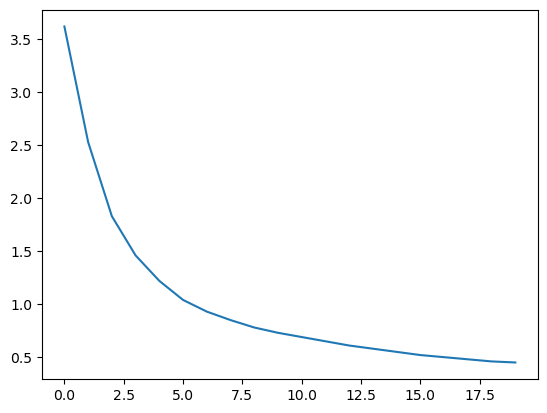

In [106]:
%matplotlib inline
plt.plot(errors)

In [185]:
%%time
nb.set_num_threads(8)
log_error=True
df['new_time'] = df['time_ff']
times_sparse_keys = list(zip(df['sparse_a'],df['sparse_b']))
errors=[]
for i in range(10):
    links_time = df.set_index(['sparse_a','sparse_b'])['new_time'].to_dict()
    
    edges = df[['a','b','new_time']].values # to build the index once and for all
    index = build_index(edges)
    reversed_index = {v:k for k, v in index.items()}
    sparse, _ = sparse_matrix(edges, index=index)

    _ , predecessors = parallel_dijkstra(sparse,
                                         directed=True,
                                         indices=zones,
                                         return_predecessors=True,
                                         num_core=1,
                                         keep_running=False)


    ab_times = assign_time(odt,links_time,predecessors,times_sparse_keys,reversed_index)
    
    df['time_correction'] = df.set_index(['a','b']).index.map(ab_times.get)
    filtre=df['time_correction']==0
    df.loc[filtre,'time_correction'] = (df[filtre]['time_ff']+df[filtre]['new_time'])/2
    df['new_time'] = df['time_correction']
    
    if log_error:
        new_time_dict = df.set_index(['sparse_a','sparse_b'])['new_time'].to_dict()
        times = get_od_time(odt,new_time_dict,times_sparse_keys,predecessors)
        od['new_time'] = od.set_index(['o','d']).index.map(times.get)
        errors.append(round(np.mean(abs(od['time']-od['new_time'])/60), 2))
        print(i,errors[-1])


0 3.62
1 2.53
2 1.86
3 1.49
4 1.26
5 1.11
6 0.96
7 0.88
8 0.8
9 0.74
CPU times: user 6min 14s, sys: 12 s, total: 6min 26s
Wall time: 1min 52s


In [107]:
# same as other algo but without jit.
'''
%%time
df['new_time'] = df['time_ff']
edges = df[['a','b','new_time']].values # to build the index once and for all
index = build_index(edges)
reversed_index = {v:k for k, v in index.items()}
sparse, _ = sparse_matrix(edges, index=index)

_ , predecessors = parallel_dijkstra(sparse,
                                     directed=True,
                                     indices=zones,
                                     return_predecessors=True,
                                     num_core=1,
                                     keep_running=False)

errors=[]
for i in range(1):
    links_time = df.set_index(['sparse_a','sparse_b'])['new_time'].to_dict()
    times={}
    for origin, destination, time in odt: 

        path = get_edge_path(get_node_path(predecessors, origin, destination))
        tot_time = sum([*map(links_time.get,path)])
        for key in path:
            try:
                times[key].append(time*links_time[key]/tot_time)
            except KeyError:
                times[key] = [time*links_time[key]/tot_time]

    #return volumes            
    # ab_volume is the volume assigned to each link indexed by the (a, b) tuple
    ab_times = {
        (reversed_index[k[0]], reversed_index[k[1]]) : np.mean(v)
        for k, v in times.items()
    }

    df['new_time'] = df.set_index(['a','b']).index.map(ab_times.get)
    new_time_dict = df.set_index(['sparse_a','sparse_b'])['new_time'].to_dict()
    times = {}
    for origin, destination, time in odt: 
        path = get_edge_path(get_node_path(predecessors, origin, destination))
        times[(origin,destination)] = sum([*map(new_time_dict.get, path)])
    od['new_time'] = od.set_index(['o','d']).index.map(times.get)
    errors.append(round(np.mean(abs(od['time']-od['new_time'])/60), 2))
    print(errors[-1])
'''

"\n%%time\ndf['new_time'] = df['time_ff']\nedges = df[['a','b','new_time']].values # to build the index once and for all\nindex = build_index(edges)\nreversed_index = {v:k for k, v in index.items()}\nsparse, _ = sparse_matrix(edges, index=index)\n\n_ , predecessors = parallel_dijkstra(sparse,\n                                     directed=True,\n                                     indices=zones,\n                                     return_predecessors=True,\n                                     num_core=1,\n                                     keep_running=False)\n\nerrors=[]\nfor i in range(1):\n    links_time = df.set_index(['sparse_a','sparse_b'])['new_time'].to_dict()\n    times={}\n    for origin, destination, time in odt: \n\n        path = get_edge_path(get_node_path(predecessors, origin, destination))\n        tot_time = sum([*map(links_time.get,path)])\n        for key in path:\n            try:\n                times[key].append(time*links_time[key]/tot_time)\n            e

In [108]:
%%time
nb.set_num_threads(8)
log_error=True

df['new_time'] = df['time_ff']
edges = df[['a','b','new_time']].values # to build the index once and for all
index = build_index(edges)
reversed_index = {v:k for k, v in index.items()}
sparse, _ = sparse_matrix(edges, index=index)

_ , predecessors = parallel_dijkstra(sparse,
                                     directed=True,
                                     indices=zones,
                                     return_predecessors=True,
                                     num_core=1,
                                     keep_running=False)

times_sparse_keys = list(zip(df['sparse_a'],df['sparse_b']))
errors2=[]
for i in range(10):
    links_time = df.set_index(['sparse_a','sparse_b'])['new_time'].to_dict()
    ab_times = assign_time(odt,links_time,predecessors,times_sparse_keys,reversed_index)
    df['new_time'] = df.set_index(['a','b']).index.map(ab_times.get)
    
    if log_error:
        new_time_dict = df.set_index(['sparse_a','sparse_b'])['new_time'].to_dict()
        times = get_od_time(odt,new_time_dict,times_sparse_keys,predecessors)
        od['new_time'] = od.set_index(['o','d']).index.map(times.get)
        errors2.append(round(np.mean(abs(od['time']-od['new_time'])/60), 2))
        print(errors2[-1])


KeyboardInterrupt: 

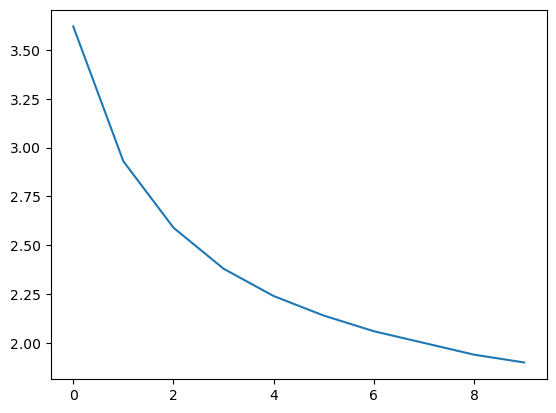

In [662]:
plt.plot(errors2)

In [186]:
x=od['time']/60
y=od['new_time']/60

errors = abs(x - y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'mins.')

x=x.values
y=y.values
regr = linear_model.LinearRegression(fit_intercept=False)#

regr.fit(x[:, np.newaxis], y)
y_pred = regr.predict(x[:, np.newaxis])
r2 = r2_score(y, x)
slope = regr.coef_[0]
intercept=0

Mean Absolute Error: 0.74 mins.


Text(0.5, 1.0, 'comparaison temps KNN (jaune = 5% des points)')

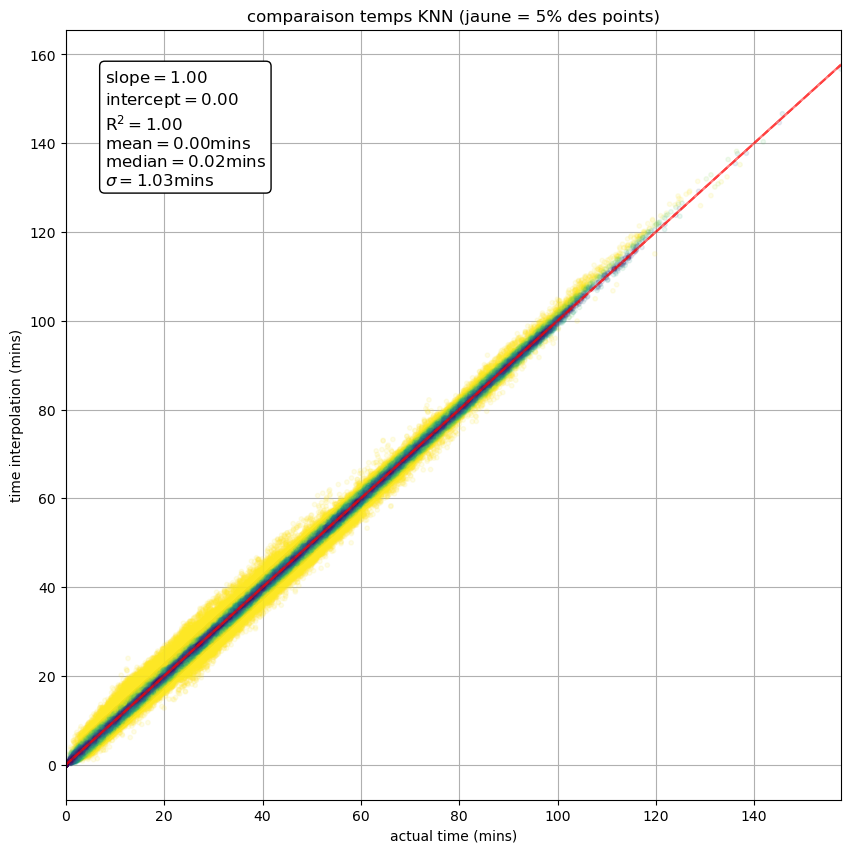

In [187]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,
            s=10,
            c=errors,
            norm=matplotlib.colors.Normalize(vmin=0, vmax=errors.quantile(0.95), clip=True),
            alpha=0.1)


maxvalue = max(max(x),max(y))
plt.plot([0,maxvalue],[0,maxvalue],'--r',alpha=0.5)
mean = np.mean(x - y)
median =np.median(x - y)
sigma = np.std(x-y)

textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, ),
     r'$\mathrm{mean}=%.2f$mins' % (mean, ),
    r'$\mathrm{median}=%.2f$mins' % (median, ),
    r'$\sigma=%.2f$mins' % (sigma, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.plot(x,x*slope+intercept,'r',alpha=0.5)
#plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)

plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('comparaison temps KNN (jaune = 5% des points)')


In [194]:
df = df[np.isfinite(df['new_time'])]
df = df[np.isfinite(df['time'])]

In [212]:
df = df[df['new_time']>0]

In [216]:
df['error'] = abs(df['new_time'] - df['time'])

/var/folders/p9/tw29fgs17yvfs17876xjxjqh0000gn/T/ipykernel_15321/3151561021.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['error'] = abs(df['new_time'] - df['time'])


In [219]:
df = df[df['error']<1000]

In [220]:
x=df['time']
y=df['new_time']

errors = abs(x - y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'mins.')

x=x.values
y=y.values
regr = linear_model.LinearRegression(fit_intercept=False)#

regr.fit(x[:, np.newaxis], y)
y_pred = regr.predict(x[:, np.newaxis])
r2 = r2_score(y, x)
slope = regr.coef_[0]
intercept=0

Mean Absolute Error: 8.96 mins.


Text(0.5, 1.0, 'comparaison temps KNN (jaune = 5% des points)')

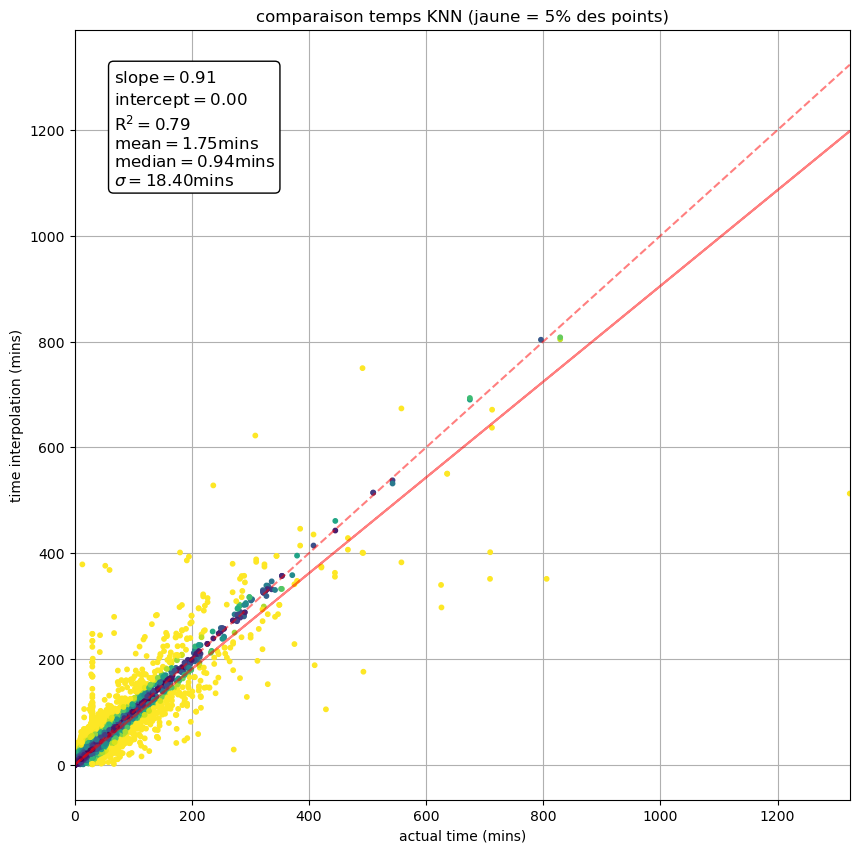

In [221]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,
            s=10,
            c=errors,
            norm=matplotlib.colors.Normalize(vmin=0, vmax=errors.quantile(0.95), clip=True),
            alpha=1)


maxvalue = max(max(x),max(y))
plt.plot([0,maxvalue],[0,maxvalue],'--r',alpha=0.5)
mean = np.mean(x - y)
median =np.median(x - y)
sigma = np.std(x-y)

textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, ),
     r'$\mathrm{mean}=%.2f$mins' % (mean, ),
    r'$\mathrm{median}=%.2f$mins' % (median, ),
    r'$\sigma=%.2f$mins' % (sigma, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.plot(x,x*slope+intercept,'r',alpha=0.5)
#plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)

plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('comparaison temps KNN (jaune = 5% des points)')


In [228]:
df['speed'] = df['length']/df['time']*3.6

In [229]:
df['speed'].describe()

count    21088.000000
mean        37.057205
std         19.240178
min          0.710000
25%         29.555000
50%         35.290000
75%         40.000000
max        467.120000
Name: speed, dtype: float64

In [59]:
(df['length']/df['time_ff']*3.6).mean()

49.5360317985782

In [60]:
(df['length']/df['time']*3.6).mean()

35.32544139583239

In [61]:
(df['length']/df['new_time']*3.6).mean()

38.788995631039995

In [120]:
links = gpd.read_file('../../../Downloads/S1/network/links.geojson')
links['time'] = links['length']/links['speedau']
links['time'] = links['time']*3600

mean_speed = (links['speedau']*links['length']).mean()/links['length'].mean()
links['time_ff'] = links['length']/mean_speed
links['time_ff'] = links['time_ff']*3600

links[np.isfinite(links['time'])]
links = links.reset_index(drop=True)
links.index = 'link_'+links.index.astype(str)
links['length'] = links['length']*1000
#links
links = links.rename(columns={'i':'a','j':'b'})
links = links[['a', 'b','length', 'time','time_ff','geometry']]
links['a'] = 'node_'+links['a'].astype(str)
links['b'] = 'node_'+links['b'].astype(str)
links.index.name='index'

In [121]:
temp_dict = df['new_time'].to_dict()
links['new_time'] = links.index.map(temp_dict.get)

In [122]:
links['error'] = (links['time']-links['new_time'])
links = links[np.isfinite(links['error'])]

In [123]:
links['error'].max()

1373.570875011816

<IPython.core.display.Javascript object>


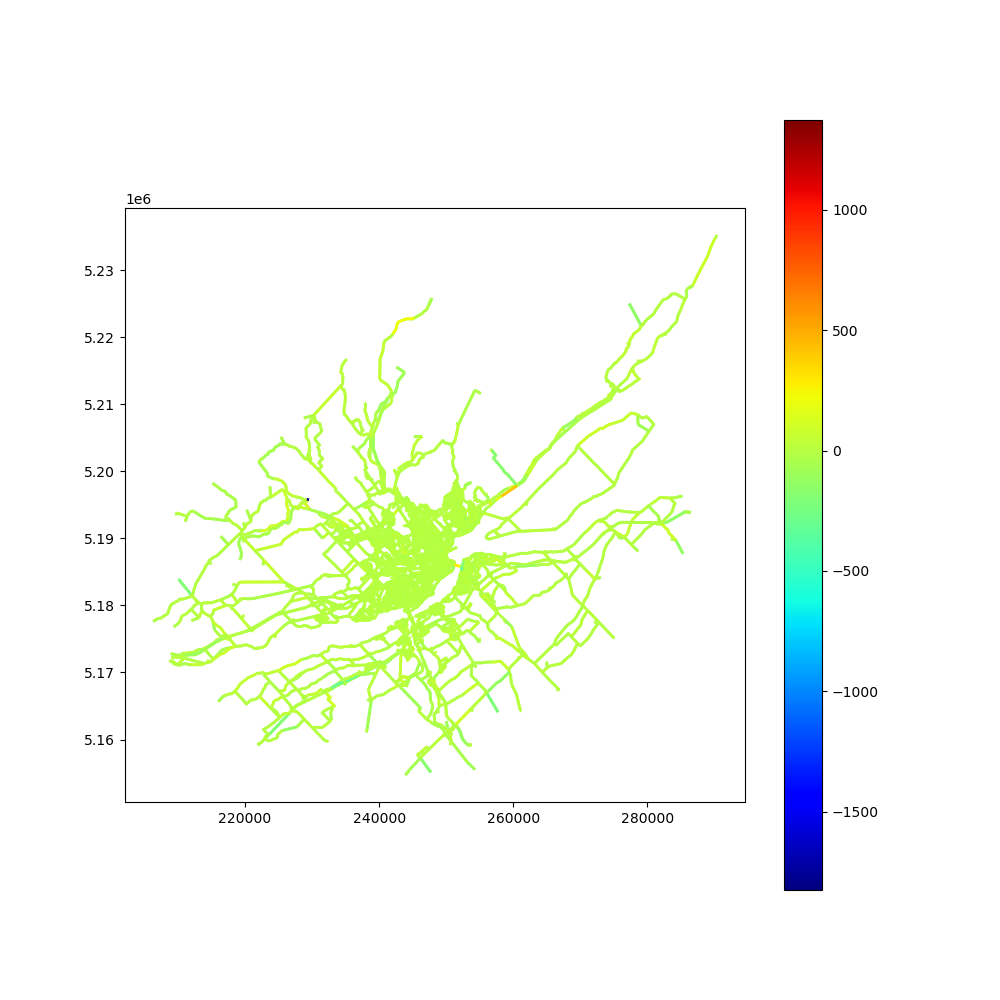

<AxesSubplot: >

In [127]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(10,10))

links.plot(ax=ax,column='error',legend=True,linewidth=2,cmap='jet')


# solve with linear relaxation

In [133]:
len(ab_times)

18104

In [289]:
%%time
index_dict = df.reset_index().set_index(['sparse_a','sparse_b'])['index'].to_dict()
links_set=set()
for origin, destination, time in odt: 
    path = get_edge_path(get_node_path(predecessors, origin, destination))
    for key in path:
        links_set.add(index_dict[key])




CPU times: user 12.4 s, sys: 60.9 ms, total: 12.4 s
Wall time: 12.4 s


In [290]:
var_dict = {val:i for i,val in enumerate(links_set)}
num_var = len(var_dict)

In [291]:
import pulp

In [320]:
model = pulp.LpProblem("dual", pulp.LpMinimize)
task_vars = pulp.LpVariable.dict("var",range(num_var),0,None,pulp.LpContinuous)

In [321]:
model += pulp.lpSum(task_vars[j] for j in range(num_var))

In [322]:
num_var

18104

In [323]:
%%time
index_dict = df.reset_index().set_index(['sparse_a','sparse_b'])['index'].to_dict()
for origin, destination, time in odt: 
    path = get_edge_path(get_node_path(predecessors, origin, destination))
    path = [*map(var_dict.get,[*map(index_dict.get,path)])]
    model += pulp.lpSum(task_vars[j] for j in path) == time

CPU times: user 1min 36s, sys: 1.58 s, total: 1min 37s
Wall time: 1min 37s


In [324]:
%%time
res =model.solve(pulp.PULP_CBC_CMD(mip=False,warmStart=False,msg=True)) 


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/simonboivin/opt/anaconda3/envs/wt/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/p9/tw29fgs17yvfs17876xjxjqh0000gn/T/e0632ae3ec7d49528c749e0c337c4613-pulp.mps timeMode elapsed initialSolve printingOptions all solution /var/folders/p9/tw29fgs17yvfs17876xjxjqh0000gn/T/e0632ae3ec7d49528c749e0c337c4613-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 792105 COLUMNS
At line 55340497 RHS
At line 56132598 BOUNDS
At line 56132599 ENDATA
Problem MODEL has 792100 rows, 18104 columns and 54530287 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
would have 0 free columns in primal, 792100 in dual
Presolve determined that the problem was infeasible with tolerance of 1e-08
Analysis indicates model infeasible or unbounded
1 infeasibilities
Analysis indicates model infeasible or unbounded
Perturbin

In [325]:
dual = []
for i in model.variables():
    if 'var' in i.name:
        dual.append((int(i.name[4:]), i.varValue))
dual.sort()# sort them by task variable name. (1 to the last one)
dual = [v[1] for v in dual] #remove "task number"
dual

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -11833.302,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 4956.8469,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 82291.703,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6855.9131,
 -47167.506,
 -32647.424,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 15090.068,
 -32718.606,
 0.0,
 0.0,
 2225.8423,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,


In [326]:
dual=np.array(dual)

In [327]:
len(dual)

18104

In [328]:
od

,origin,destination,time,o,d,new_time,pulp_time
0,zone_0,zone_0,0.000000,0,1997,0.000000,0.000000
1,zone_0,zone_1,91.485771,0,1809,76.188853,91.485770
2,zone_0,zone_2,121.471542,0,6339,469.837000,121.471543
3,zone_0,zone_3,121.466245,0,1275,451.638381,127.052402
4,zone_0,zone_4,140.248033,0,2930,651.283853,177.926679
...,...,...,...,...,...,...,...
792095,zone_889,zone_885,2069.012300,877,8468,2179.693403,2821.116246
792096,zone_889,zone_886,2079.277869,877,5408,2160.170641,2597.185427
792097,zone_889,zone_887,1649.319320,877,6306,1816.893141,2330.902072
792098,zone_889,zone_888,366.842621,877,3942,400.678440,399.688251


In [329]:
times = {}
for origin, destination, time in odt: 
    path = get_edge_path(get_node_path(predecessors, origin, destination))
    path = [*map(var_dict.get,[*map(index_dict.get,path)])]
    times[(origin,destination)] = dual[path].sum()
od['pulp_time'] = od.set_index(['o','d']).index.map(times.get)

In [330]:
x=od['time']/60
y=od['pulp_time']/60

errors = abs(x - y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'mins.')

Mean Absolute Error: 812.06 mins.


Text(0.5, 1.0, 'comparaison temps KNN (jaune = 5% des points)')

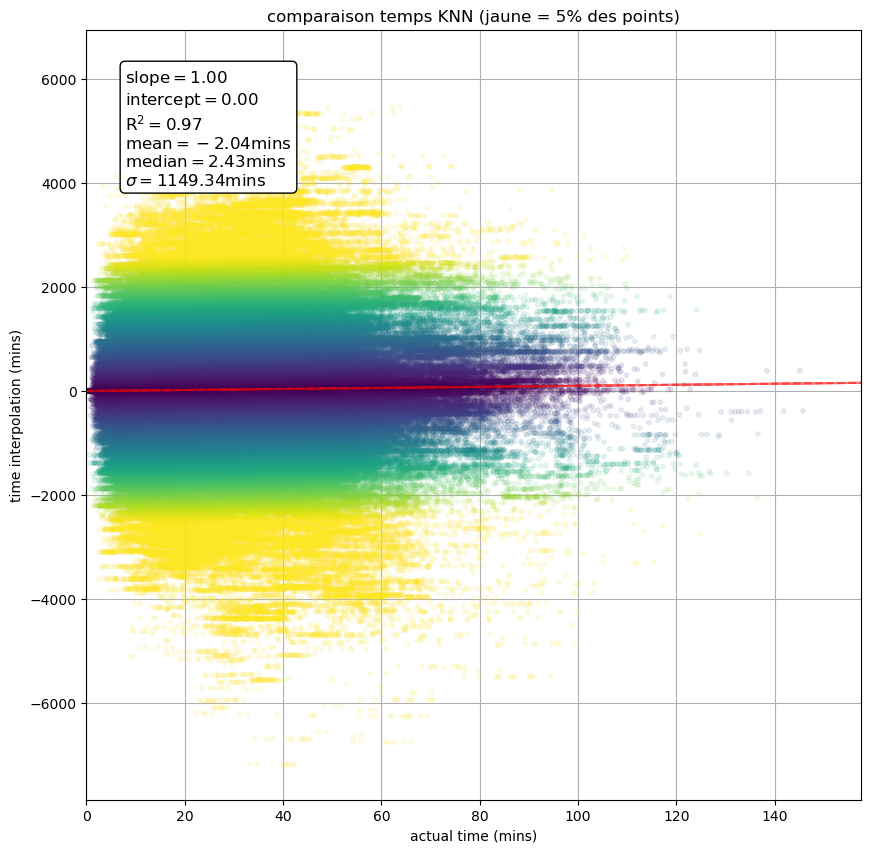

In [331]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,
            s=10,
            c=errors,
            norm=matplotlib.colors.Normalize(vmin=0, vmax=errors.quantile(0.95), clip=True),
            alpha=0.1)


maxvalue = max(max(x),max(y))
plt.plot([0,maxvalue],[0,maxvalue],'--r',alpha=0.5)
mean = np.mean(x - y)
median =np.median(x - y)
sigma = np.std(x-y)

textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, ),
     r'$\mathrm{mean}=%.2f$mins' % (mean, ),
    r'$\mathrm{median}=%.2f$mins' % (median, ),
    r'$\sigma=%.2f$mins' % (sigma, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.plot(x,x*slope+intercept,'r',alpha=0.5)
#plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)

plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('comparaison temps KNN (jaune = 5% des points)')


In [36]:
def get_od_time(odt,new_time_dict,volumes_sparse_keys,predecessors):
    numba_new_time_dict = nb.typed.Dict.empty(
            key_type=nb.types.UniTuple(nb.types.int64, 2), 
            value_type=nb.types.float64
            )
    numba_times = nb.typed.Dict.empty(
        key_type=nb.types.UniTuple(nb.types.int64, 2), 
        value_type=nb.types.float64
        )
    for key in volumes_sparse_keys:
        numba_new_time_dict[key] = new_time_dict[key]
    for i,j,_ in odt:
        numba_times[(i,j)] = 0
    times = fast_get_time(odt,predecessors,numba_times,numba_new_time_dict)
    return dict(times)

In [37]:
%%time
errors=[]
df['new_time'] = df['time_ff']
times_sparse_keys = list(zip(df['sparse_a'],df['sparse_b']))
links_time = df.set_index(['sparse_a','sparse_b'])['new_time'].to_dict()

edges = df[['a','b','new_time']].values # to build the index once and for all
index = build_index(edges)
reversed_index = {v:k for k, v in index.items()}
sparse, _ = sparse_matrix(edges, index=index)

_ , predecessors = parallel_dijkstra(sparse,
                                     directed=True,
                                     indices=zones,
                                     return_predecessors=True,
                                     num_core=1,
                                     keep_running=False)

'''
times={}
for origin, destination, time in odt: 

    path = get_edge_path(get_node_path(predecessors, origin, destination))
    tot_time = sum([*map(links_time.get,path)])
    for key in path:
        try:
            times[key].append(time*links_time[key]/tot_time)
        except KeyError:
            times[key] = [time*links_time[key]/tot_time]
#return volumes            
# ab_volume is the volume assigned to each link indexed by the (a, b) tuple
ab_times = {
    (reversed_index[k[0]], reversed_index[k[1]]) : np.mean(v)
    for k, v in times.items()
}
'''
ab_times2 = assign_time(odt,links_time,predecessors,times_sparse_keys,reversed_index)

CPU times: user 21.9 s, sys: 346 ms, total: 22.2 s
Wall time: 4.89 s


In [38]:
ab_times2

{('node_1', 'node_1490'): 29.982331446086352,
 ('node_1', 'node_12430'): 6.463057156788322,
 ('node_2', 'node_12449'): 23.14646741773309,
 ('node_3', 'node_12360'): 10.685911982116602,
 ('node_3', 'node_12363'): 19.036536465926634,
 ('node_3', 'node_12428'): 15.700116330123665,
 ('node_4', 'node_12363'): 78.68628352558713,
 ('node_4', 'node_12428'): 10.135209166490823,
 ('node_5', 'node_1470'): 13.801231869177654,
 ('node_5', 'node_1479'): 9.711540233431233,
 ('node_6', 'node_1452'): 20.840203292081476,
 ('node_6', 'node_12367'): 11.554433576602055,
 ('node_7', 'node_1441'): 4.113114544649452,
 ('node_7', 'node_1509'): 1.9107588510368907,
 ('node_8', 'node_1480'): 12.695500130147805,
 ('node_8', 'node_1489'): 2.3007808777846472,
 ('node_9', 'node_12440'): 1.6283486438976589,
 ('node_9', 'node_12451'): 7.551274020782593,
 ('node_10', 'node_12451'): 8.453931740567898,
 ('node_10', 'node_12452'): 17.56783472310555,
 ('node_10', 'node_12456'): 8.187059414101785,
 ('node_10', 'node_12466'):

In [39]:
df

,a,b,length,time,time_ff,sparse_a,sparse_b,new_time
link_0,node_1,node_1490,119.994,29.998500,8.720489,5573,2864,8.720489
link_1,node_1,node_12430,77.706,30.015193,5.647235,5573,1112,5.647235
link_2,node_2,node_12449,236.065,29.997670,17.155876,1852,8768,17.155876
link_3,node_3,node_12360,132.616,30.007392,9.637785,2580,7235,9.637785
link_4,node_3,node_12363,133.906,29.997610,9.731534,2580,3272,9.731534
...,...,...,...,...,...,...,...,...
zlink_1775,node_770,zone_885,0.000,0.000000,0.000000,185,5234,0.000000
zlink_1776,node_35304,zone_886,0.000,0.000000,0.000000,3488,2147,0.000000
zlink_1777,node_772,zone_887,0.000,0.000000,0.000000,4919,4696,0.000000
zlink_1778,node_29172,zone_888,0.000,0.000000,0.000000,5137,8004,0.000000


23903

In [699]:
df

,a,b,length,time,time_ff,sparse_a,sparse_b,new_time,time_correction
link_0,node_1,node_1490,119.994,29.998500,8.720489,7247,3136,8.720489,0.000000
link_1,node_1,node_12430,77.706,30.015193,5.647235,7247,1956,5.647235,8.658306
link_2,node_2,node_12449,236.065,29.997670,17.155876,8608,1748,17.155876,29.464132
link_3,node_3,node_12360,132.616,30.007392,9.637785,6863,1243,9.637785,13.897587
link_4,node_3,node_12363,133.906,29.997610,9.731534,6863,7628,9.731534,0.000000
...,...,...,...,...,...,...,...,...,...
zlink_1775,node_770,zone_885,0.000,0.000000,0.000000,5568,8468,0.000000,0.000000
zlink_1776,node_35304,zone_886,0.000,0.000000,0.000000,8242,5408,0.000000,0.000000
zlink_1777,node_772,zone_887,0.000,0.000000,0.000000,7683,6306,0.000000,0.000000
zlink_1778,node_29172,zone_888,0.000,0.000000,0.000000,683,3942,0.000000,0.000000


In [ ]:
df['time_correction'] = df.set_index(['a','b']).index.map(ab_times.get)
    df.loc[np.isfinite(df['time_correction']),'new_time'] = df.loc[np.isfinite(df['time_correction']),'time_correction']